In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Input, GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNetV3Small
import pickle
from PIL import Image
import cv2
import random


In [2]:
dataset = 'D:/Study/Year 3 Semester 2/Research Project/age_and_gender/UTKFace'
augmented_dataset = 'D:/Study/Year 3 Semester 2/Research Project/age_and_gender/Augmented Dataset'

Dataset Augmentation

In [5]:
rotation_range = 20   

def random_rotation(image, rotation_range):
    angle = random.uniform(-rotation_range, rotation_range)
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

for filename in os.listdir(dataset):
    if filename.endswith('.jpg'):
        input_path = os.path.join(dataset, filename)
        image = cv2.imread(input_path)

        for i in range(4):
            augmented_image = image.copy()
            if i == 0:
                augmented_image = image.copy()
            elif i == 1:
                augmented_image = cv2.flip(augmented_image, 1)  # Horizontal flip
            elif i == 2:
                augmented_image = cv2.flip(augmented_image, 0)  # Vertical flip
            elif i == 3:
                augmented_image = random_rotation(augmented_image, rotation_range)
            
            output_path = os.path.join(augmented_dataset, f"{i}_{filename}")
            cv2.imwrite(output_path, augmented_image)


Define Class Ranges

In [3]:
def class_labels_reassign(age):
    if 1 <= age <= 5:
        return 0
    elif 6 <= age <= 15:
        return 1
    elif 16 <= age <= 26:
        return 2
    elif 27 <= age <= 35:
        return 3
    elif 36 <= age <= 50:
        return 4
    elif 51 <= age <= 70:
        return 5
    elif 71 <= age <= 90:
        return 6
    else:
        return 7

Age and Gender data extraction

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(augmented_dataset):
    image_path = os.path.join(augmented_dataset, filename)
    temp = filename.split('_')
    age = class_labels_reassign(int(temp[1]))
    gender = int(temp[2])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [5]:
df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df['gender'] = gender_labels
df.head()

,image,age,gender
0,D:/Study/Year 3 Semester 2/Research Project/ag...,7,0
1,D:/Study/Year 3 Semester 2/Research Project/ag...,7,0
2,D:/Study/Year 3 Semester 2/Research Project/ag...,7,1
3,D:/Study/Year 3 Semester 2/Research Project/ag...,7,1
4,D:/Study/Year 3 Semester 2/Research Project/ag...,7,1


In [6]:
gender_dict = {0:'Male', 1:'Female'}
age_dict = {0:'1-5', 1:'6-15',2:'16-26', 3:'27-35',4:'36-50', 5:'51-70', 6:'71-90', 7:'91-116'}

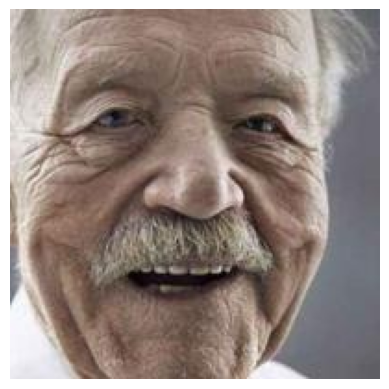

In [7]:
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

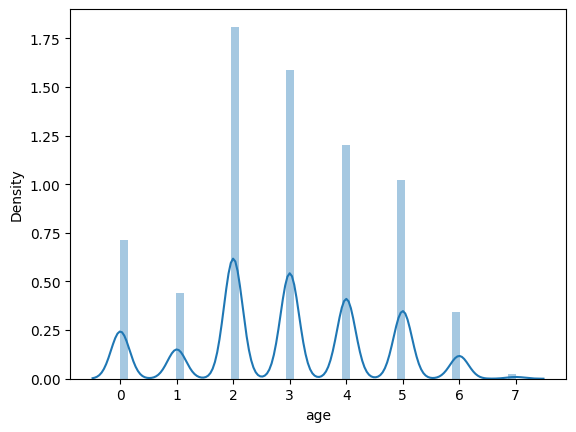

In [8]:
sns.distplot(df['age']);

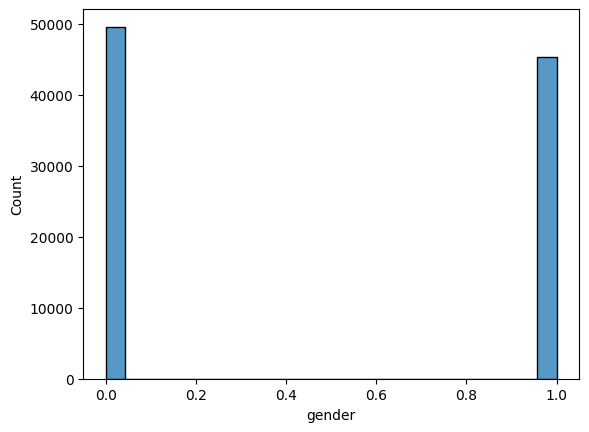

In [9]:
sns.histplot(df['gender']);

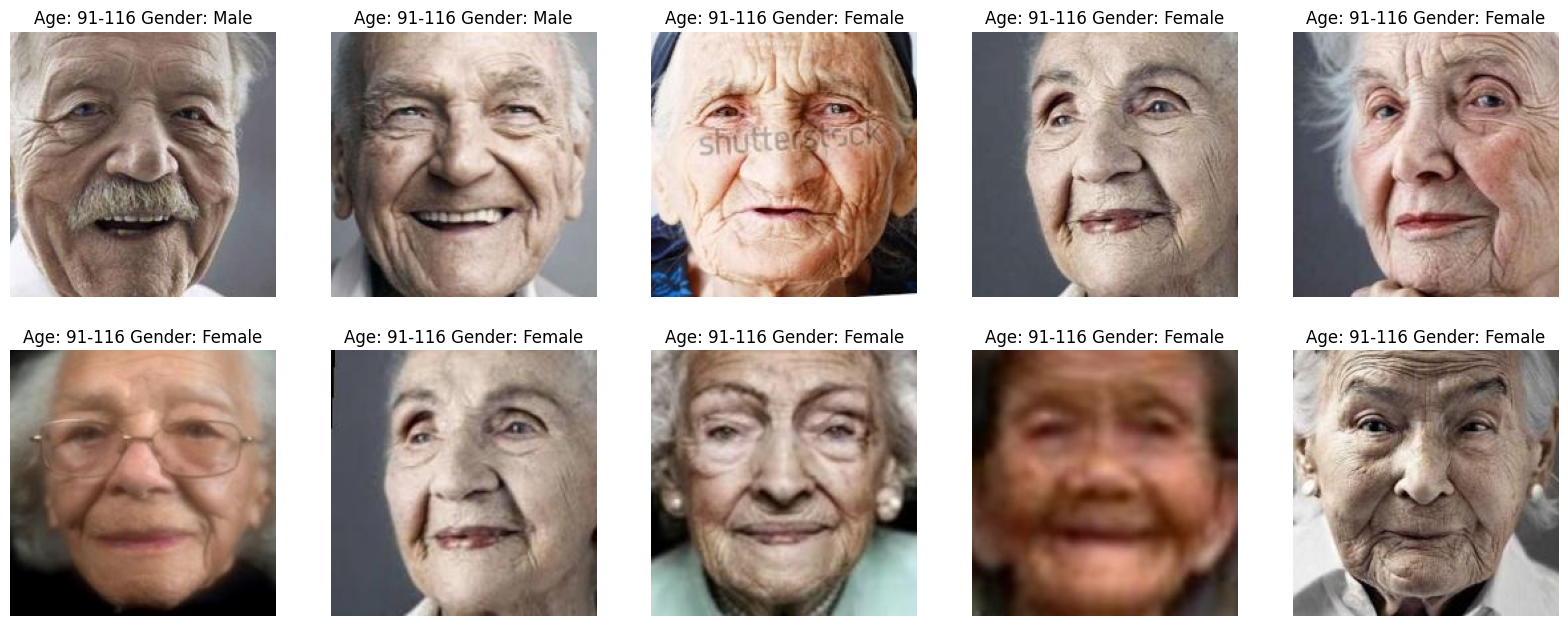

In [10]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age_dict[age]} Gender: {gender_dict[gender]}")
    plt.axis('off')

Extract features from images

In [11]:
def extract_features(images):
    features = []
    for image in (images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
input_pic = extract_features(df['image'])

In [13]:
input_pic.shape

(94832, 128, 128, 1)

In [14]:
input_pic = input_pic/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

Machine Learning Model

In [17]:
# Load MobileNetV3 with pre-trained weights
base_model = MobileNetV3Small(input_shape=(128, 128, 3), include_top=False, weights='imagenet')  # Set the input shape to (128, 128, 3)

# Adjust the input layer to handle grayscale images
input_layer = Input(shape=input_shape)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(input_layer)  # Convert single channel to three channels
x = base_model(x)

# Additional Layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.3)(x)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(x)
output_2 = Dense(8, activation='softmax', name='age_out')(x)

model = Model(inputs=input_layer, outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 3)          30        ['input_2[0][0]']             
                                                                                                  
 MobilenetV3small (Function  (None, 4, 4, 576)            939120    ['conv2d[0][0]']              
 al)                                                                                              
                                                                                                  
 global_average_pooling2d (  (None, 576)                  0         ['MobilenetV3small[0][0]']

In [37]:
history = model.fit(x=[input_pic], y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Epoch 1/10
1779/1779 [==============================] - 752s 423ms/step - loss: 0.4461 - gender_out_loss: 0.0672 - age_out_loss: 0.3789 - gender_out_accuracy: 0.9734 - age_out_accuracy: 0.8443 - val_loss: 10.6661 - val_gender_out_loss: 0.7285 - val_age_out_loss: 9.9376 - val_gender_out_accuracy: 0.7339 - val_age_out_accuracy: 0.2160
Epoch 2/10
1779/1779 [==============================] - 688s 387ms/step - loss: 0.3947 - gender_out_loss: 0.0612 - age_out_loss: 0.3335 - gender_out_accuracy: 0.9765 - age_out_accuracy: 0.8657 - val_loss: 6.3462 - val_gender_out_loss: 1.7220 - val_age_out_loss: 4.6242 - val_gender_out_accuracy: 0.5384 - val_age_out_accuracy: 0.1074
Epoch 3/10
1779/1779 [==============================] - 689s 387ms/step - loss: 0.3466 - gender_out_loss: 0.0560 - age_out_loss: 0.2906 - gender_out_accuracy: 0.9783 - age_out_accuracy: 0.8845 - val_loss: 8.1377 - val_gender_out_loss: 2.4454 - val_age_out_loss: 5.6924 - val_gender_out_accuracy: 0.5297 - val_age_out_accuracy: 0.24

In [45]:
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

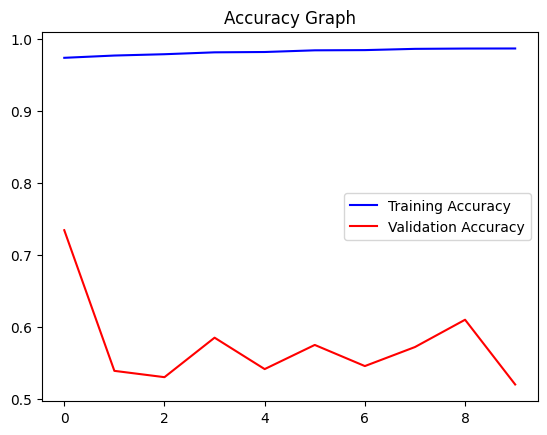

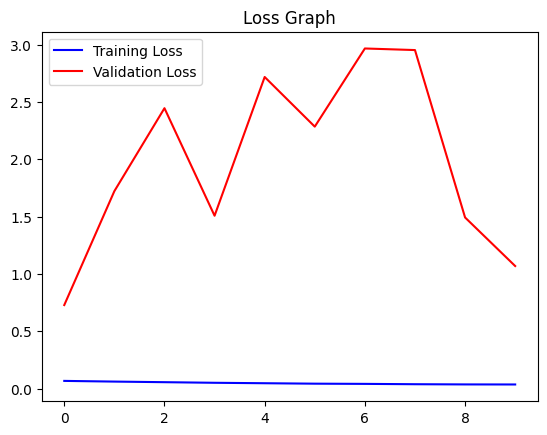

In [51]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

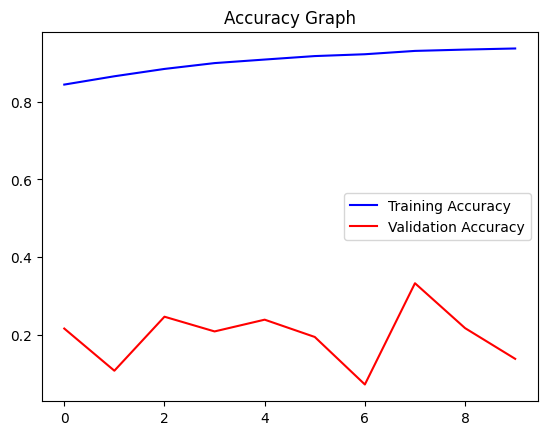

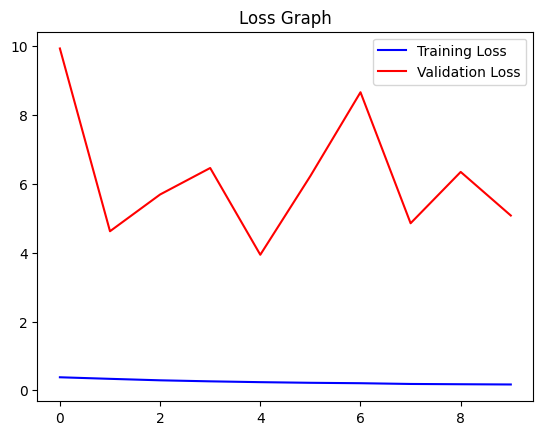

In [40]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male 
Original Age Range: 16-26
1/1 [==============================] - 0s 26ms/step
Predicted Gender: Male 
Predicted Age Range: 16-26


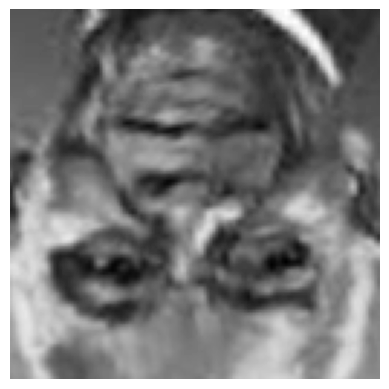

In [49]:
image_index = 53211
print("Original Gender:", gender_dict[y_gender[image_index]], "\nOriginal Age Range:", age_dict[y_age[image_index]])

pred = loaded_model.predict(input_pic[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
# predicted_age_range = age_dict[round(pred[1][0][0])]
predicted_age = pred[1]
predicted_age_class = predicted_age.argmax(axis=1)
if predicted_age_class == [0]:
        predicted_age_range =  '1-5'
elif predicted_age_class == [1]:
    predicted_age_range =  '6-15'
elif predicted_age_class == [2]:
    predicted_age_range =  '16-26'
elif predicted_age_class == [3]:
    predicted_age_range =  '27-35'
elif predicted_age_class == [4]:
    predicted_age_range =  '36-50'
elif predicted_age_class == [5]:
    predicted_age_range =  '51-70'
elif predicted_age_class == [6]:
    predicted_age_range =  '71-90'
else:
    predicted_age_range =  '91-116'
print("Predicted Gender:", pred_gender, "\nPredicted Age Range:", predicted_age_range)
plt.axis('off')
plt.imshow(input_pic[image_index].reshape(128, 128), cmap='gray');